### Caso 1: Processamento de Pedidos em um E-commerce de Pequeno Porte

**Cenário:**  
Uma loja virtual recebe pedidos de clientes de forma aleatória durante o dia. O objetivo é simular o fluxo de pedidos, o atendimento por parte dos funcionários responsáveis por embalar e preparar os pedidos para envio e o tempo total que cada pedido fica no sistema.

**Informações e Parâmetros Necessários:**  
- **Chegada dos Pedidos:**  
  - Os pedidos chegam seguindo um processo de Poisson.   
  - Parâmetro Lambda: taxa média de chegada (5 minutos).

- **Recursos de Atendimento:**  
  - Há 2 funcionários responsáveis pelo processamento dos pedidos.  
  - Cada funcionário processa um pedido por vez.

- **Tempo de Processamento:**  
  - O tempo para embalar e preparar um pedido segue uma distribuição exponencial com média de 3 minutos.  
  - Esse tempo representa o serviço prestado por um funcionário.

- **Duração da Simulação:**  
  - Simular o funcionamento durante um dia de operação (por exemplo, 8 horas de expediente).

- **Objetivos:**  
  - Medir o tempo médio de espera dos pedidos na fila.  
  - Verificar a utilização dos funcionários.  
  - Analisar se o tempo de processamento atende à demanda e identificar possíveis gargalos.

In [97]:
import simpy
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [98]:
formatter = logging.Formatter('%(asctime)s | %(levelname)2s | %(message)s', datefmt="%Y-%m-%d %H:%M")
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

for handler in logger.handlers:
    logger.removeHandler(handler)

logger.addHandler(console_handler)

In [179]:
class Packaging:
    def __init__(self, env, num_workers=2):
        self.workers = simpy.Resource(env, num_workers)
        self.env = env
        self.orders = {}

    def package(self, name):
        with self.workers.request() as req:
            self.orders[name] = {'worker_req_time':self.env.now}
            yield req
            self.orders[name]['got_worker_time'] = self.env.now
            time_to_finish = random.expovariate(1/3.5)
            self.orders[name]['time_to_finish'] = time_to_finish
            yield self.env.timeout(time_to_finish)
            self.orders[name]['finished'] = self.env.now
            
    def do(self, name):
        return self.env.process(self.package(name=name))

class Operation:
    def __init__(self, env, pack_op):
        self.env = env
        self.pack_op = pack_op
        self.order_data = {}

    def package_order(self):
        i = 1
        while True:
            self.order_data[i] = env.now
            tt_next_request = random.expovariate(1/5)
            self.pack_op.do(name=i)
            yield env.timeout(tt_next_request)
            i += 1

In [201]:
env = simpy.Environment()
ecom = Packaging(env, num_workers=2)
op = Operation(env, ecom)

env.process(op.package_order())
env.run(until=8*60)

In [202]:
stats = (
    pd.DataFrame.from_dict(op.order_data, orient='index', columns=['time_created'])
    .merge(pd.DataFrame.from_dict(ecom.orders, orient='index'), left_index=True, right_index=True)
    .assign(time_waiting = lambda x: (x.got_worker_time - x.time_created))
).round(4)

In [203]:
num_orders_created = []
num_orders_delivered = []
net_orders = []

for time in range(0,8*60):
    created = stats.query("time_created <= @time").shape[0]
    num_orders_created.append(created)
    delivered = stats.query("finished <= @time").shape[0]
    num_orders_delivered.append(delivered)
    net = delivered - created
    net_orders.append(net)

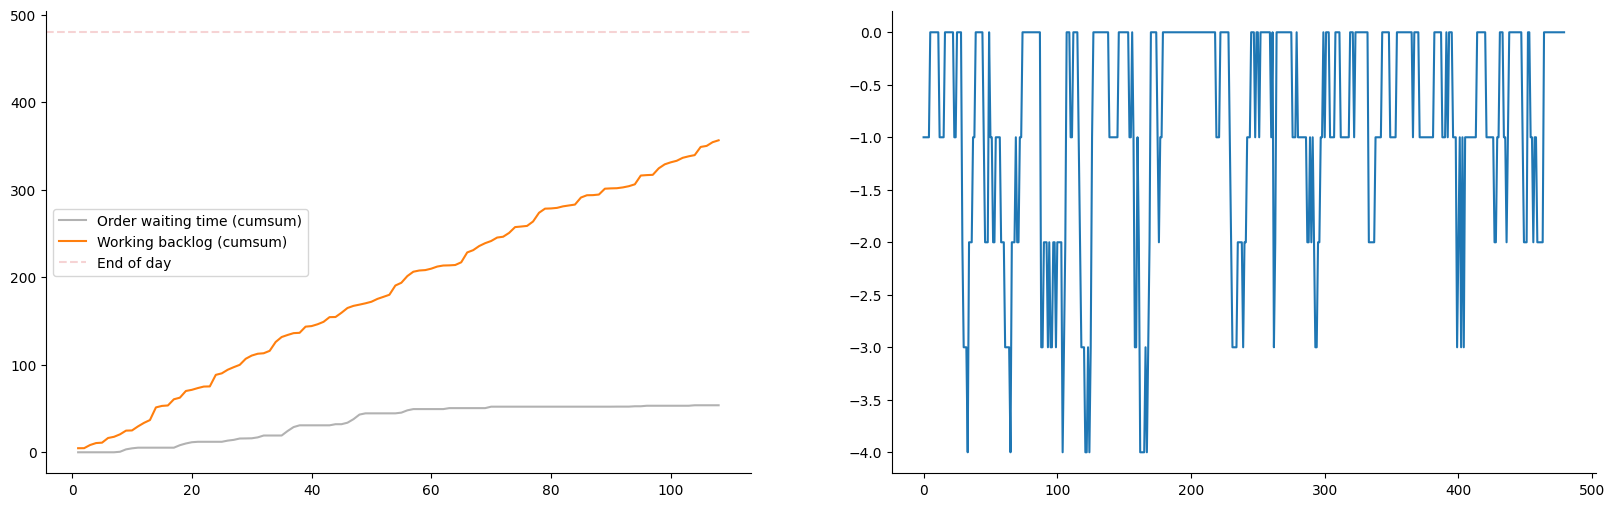

In [204]:
f, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(stats.time_waiting.cumsum(), label='Order waiting time (cumsum)', color='black', alpha=0.3)
ax[0].plot(stats.time_to_finish.cumsum(), label='Working backlog (cumsum)', color='tab:orange')
ax[0].axhline(8*60, label='End of day', color='tab:red', alpha=0.2, ls='--')
ax[0].legend()
ax[1].plot(net_orders)

In [111]:
results = []
custo_worker = 5155.56 / 22

for i in tqdm(range(5_000)):
    n_workers = 1
    ## run the simulation
    env = simpy.Environment()
    ecom = Packaging(env, num_workers=n_workers)
    op = Operation(env, ecom)
    
    env.process(op.package_order())
    env.run(until=8*60)

    ## get stats
    run_df = (
        pd.DataFrame.from_dict(ecom.orders, orient='index')
        .assign(waiting_time = lambda x: x.got_worker_time - x.worker_req_time)
        .assign(order_waited = lambda x: (x.waiting_time != 0).astype(int))
    )
    
    stats = run_df.order_waited.value_counts().to_dict()
    
    run_stats = {
        "orders_worked":run_df.shape[0],
        "n_orders_waited":stats.get(1,0),
        "n_orders_instant":stats.get(0,0),
        "revenue":(stats.get(1,0)*39.9*0.5)+(stats.get(0,0)*39.9*1)-(n_workers*custo_worker),
    }

    results.append(run_stats)

  0%|          | 0/5000 [00:00<?, ?it/s]

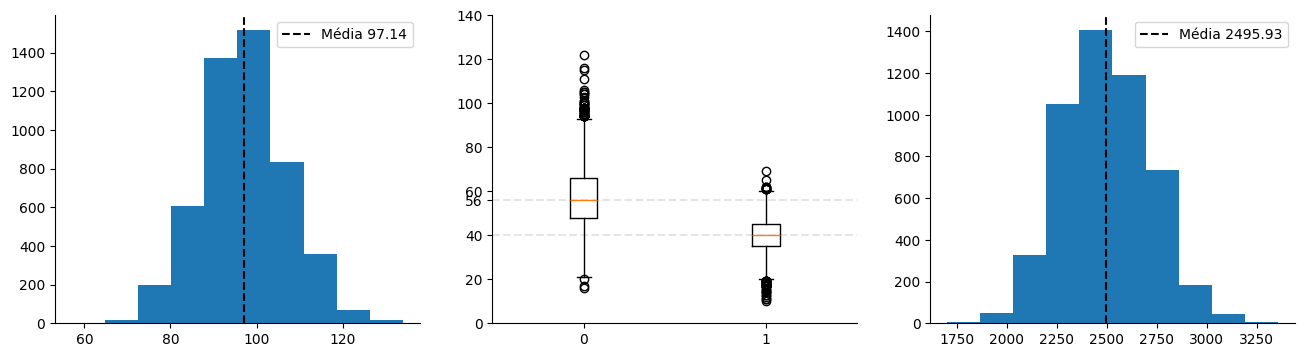

In [112]:
df = pd.DataFrame(results)

f, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].hist(df.orders_worked)
ax[0].axvline(df.orders_worked.mean(),ls='--',color='black', label=f"Média {df.orders_worked.mean().round(2)}")
ax[0].legend()


ax[1].boxplot(
    [df.n_orders_waited,
     df.n_orders_instant],
    positions=[0,1]
)

ax[1].axhline(df.n_orders_waited.median(),ls="--",color="grey",alpha=0.2, zorder=-1)
ax[1].axhline(df.n_orders_instant.median(),ls="--",color="grey",alpha=0.2, zorder=-1)

yticks = sorted(set(list(ax[1].get_yticks())+[df.n_orders_waited.median(),df.n_orders_instant.median()]))
ax[1].set_yticks(yticks)

ax[2].hist(df.revenue)
ax[2].axvline(df.revenue.mean(),ls='--',color='black', label=f"Média {df.revenue.mean().round(2)}")

ax[2].legend()

plt.show()

In [7]:
class Packaging:
    def __init__(self, env):
        self.workers = simpy.Resource(env, capacity=2)
        self.env = env

    def package(self, name):
        with self.workers.request() as req:
            logger.info(f"Order #{name:03d} | Resource Request   | Sim time: {round(self.env.now,2):04}")
            yield req
            logger.info(f"Order #{name:03d} | Got Resource       | Sim time: {round(self.env.now,2):04}")
            time_to_finish = random.expovariate(1/3)
            start_time = self.env.now
            logger.info(f"Order #{name:03d} | Start packaging    | Sim time: {round(self.env.now,2):04}")
            yield self.env.timeout(time_to_finish)
            logger.info(f"Order #{name:03d} | Finished packaging | Sim time: {round(self.env.now,2):04}")

def package_order(env, name, packaging_op):
    logger.info(f"Order #{name:03d} | Created            | Sim time: {round(env.now,2):04}")
    yield env.process(packaging_op.package(name=name))

def order_generator(env, pack_op):
    i = 1
    while True:
        tt_next_request = random.expovariate(1/5)  # 5 min on avg
        env.process(package_order(env, i, pack_op))
        yield env.timeout(tt_next_request)
        i += 1

Para chegar na nota 10/10, você precisaria:

Adicionar coleta de métricas:

* Registrar o tempo que cada pedido passa na fila (wait_time = start_time - create_time)
* Calcular o tempo total no sistema (total_time = finish_time - create_time)
* Medir a utilização dos recursos (quanto tempo os funcionários ficam ocupados)


Definir parâmetros da simulação explicitamente:

* Duração de 8 horas (480 minutos)
* Inicializar as variáveis de estatísticas


Produzir relatório de resultados:

* Calcular médias, máximos e mínimos dos tempos de espera
* Gerar gráficos de distribuição de tempos
* Mostrar taxa de utilização dos funcionários


Implementar variações de demanda ao longo do dia (períodos de pico)
Adicionar opções para simular diferentes números de funcionários
Incluir pausas dos funcionários (almoço, descanso)

In [8]:
env = simpy.Environment()
ecom = Packaging(env)
env.process(order_generator(env,ecom))
env.run(until=8*60)

2025-03-26 23:49 | INFO | Order #001 | Created            | Sim time: 0000
2025-03-26 23:49 | INFO | Order #001 | Resource Request   | Sim time: 0000
2025-03-26 23:49 | INFO | Order #001 | Got Resource       | Sim time: 0000
2025-03-26 23:49 | INFO | Order #001 | Start packaging    | Sim time: 0000
2025-03-26 23:49 | INFO | Order #001 | Finished packaging | Sim time: 4.45
2025-03-26 23:49 | INFO | Order #002 | Created            | Sim time: 14.3
2025-03-26 23:49 | INFO | Order #002 | Resource Request   | Sim time: 14.3
2025-03-26 23:49 | INFO | Order #002 | Got Resource       | Sim time: 14.3
2025-03-26 23:49 | INFO | Order #002 | Start packaging    | Sim time: 14.3
2025-03-26 23:49 | INFO | Order #003 | Created            | Sim time: 14.41
2025-03-26 23:49 | INFO | Order #003 | Resource Request   | Sim time: 14.41
2025-03-26 23:49 | INFO | Order #003 | Got Resource       | Sim time: 14.41
2025-03-26 23:49 | INFO | Order #003 | Start packaging    | Sim time: 14.41
2025-03-26 23:49 | IN

In [9]:
import simpy
import numpy as np
import random
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(encoding='utf-8', level=logging.INFO)

In [10]:
def request_generator(env):
    i = 1
    while True:
        tt_next_request = random.expovariate(1/5)  # 5 min on avg
        logger.info(f"Request {i} has arrived at {env.now}")
        yield env.timeout(tt_next_request)

env = simpy.Environment()
env.process(request_generator(env))
env.run(until=10)

2025-03-26 23:49 | INFO | Request 1 has arrived at 0
INFO:__main__:Request 1 has arrived at 0
2025-03-26 23:49 | INFO | Request 1 has arrived at 1.4706197360690267
INFO:__main__:Request 1 has arrived at 1.4706197360690267
2025-03-26 23:49 | INFO | Request 1 has arrived at 3.3277506193558937
INFO:__main__:Request 1 has arrived at 3.3277506193558937
2025-03-26 23:49 | INFO | Request 1 has arrived at 5.1383177084167215
INFO:__main__:Request 1 has arrived at 5.1383177084167215
2025-03-26 23:49 | INFO | Request 1 has arrived at 5.932129695610793
INFO:__main__:Request 1 has arrived at 5.932129695610793
2025-03-26 23:49 | INFO | Request 1 has arrived at 7.983281997420722
INFO:__main__:Request 1 has arrived at 7.983281997420722


In [11]:
# Gerar número de pedidos para cada hora do dia
for hora in range(8):  # 8 horas de trabalho
    num_pedidos = np.random.poisson(12)  # lambda = 12 pedidos/hora
    print(f"Hora {hora+1}: {num_pedidos} pedidos")

Hora 1: 12 pedidos
Hora 2: 10 pedidos
Hora 3: 11 pedidos
Hora 4: 16 pedidos
Hora 5: 15 pedidos
Hora 6: 8 pedidos
Hora 7: 12 pedidos
Hora 8: 13 pedidos


In [12]:
import random

In [13]:
hora_atual = 0
tempo_atual = 0
pedidos_por_hora = [0] * 8

while tempo_atual < 8*60:  # 8 horas em minutos
    # Gerar tempo até próximo pedido (distribuição exponencial)
    tempo_ate_proximo = random.expovariate(1/5)  # média = 5 minutos
    
    # Atualizar o tempo atual
    tempo_atual += tempo_ate_proximo
    
    # Se ainda estamos dentro do expediente
    if tempo_atual < 8*60:
        # Determinar em qual hora este pedido chegou
        hora = int(tempo_atual // 60)
        # Incrementar contador para esta hora
        pedidos_por_hora[hora] += 1

for hora in range(8):
    print(f"Hora {hora+1}: {pedidos_por_hora[hora]} pedidos")

Hora 1: 11 pedidos
Hora 2: 16 pedidos
Hora 3: 14 pedidos
Hora 4: 13 pedidos
Hora 5: 7 pedidos
Hora 6: 12 pedidos
Hora 7: 10 pedidos
Hora 8: 13 pedidos


In [14]:
# Para simular quantos pedidos chegarão em 1 hora
pedidos_em_uma_hora = np.random.poisson(12)  # lambda = 12

# Para simular quantos pedidos chegarão em 5 minutos
pedidos_em_cinco_minutos = np.random.poisson(1)  # lambda = 1

In [15]:
pedidos_em_uma_hora

5

In [16]:
pedidos_em_cinco_minutos

0

In [17]:
def gerador_pedidos(env):
    while True:
        # Chegou um pedido
        tempo_ate_proximo = random.expovariate(1/5)  # média = 5 minutos
        print(f"Pedido chegou no tempo {env.now}, vamos esperar {tempo_ate_proximo} até o próximo")
        
        yield env.timeout(tempo_ate_proximo)

env = simpy.Environment()
env.process(gerador_pedidos(env))
env.run(until=10)

Pedido chegou no tempo 0, vamos esperar 6.225370022934947 até o próximo
Pedido chegou no tempo 6.225370022934947, vamos esperar 5.265876663452471 até o próximo


In [18]:
tempo = 60
x = [[np.random.poisson(1/5) for _ in range(tempo)] for _ in range(200)]

(array([ 7., 11.,  7., 42., 24., 46., 37., 14.,  6.,  6.]),
 array([ 4. ,  5.6,  7.2,  8.8, 10.4, 12. , 13.6, 15.2, 16.8, 18.4, 20. ]),
 <BarContainer object of 10 artists>)

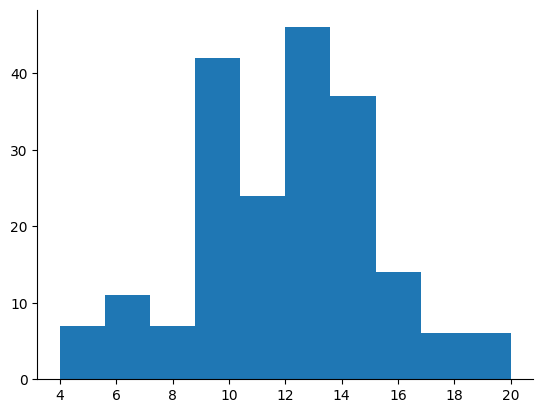

In [19]:
plt.hist([sum(hora) for hora in x])